In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz,plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('preprosseced.csv')

print(df.dtypes)

Unnamed: 0                int64
Company                  object
TypeName                 object
Inches                  float64
Ram                     float64
OpSys                    object
Weight                  float64
Price_euros             float64
Screen                   object
ScreenW                 float64
ScreenH                 float64
Touchscreen              object
IPSpanel                 object
RetinaDisplay            object
CPU_brand                object
CPU_base_clock_speed    float64
PrimaryStorage            int64
PrimaryStorageType       object
SecondaryStorage          int64
SecondaryStorageType     object
GPU_company              object
dtype: object


In [2]:
def classify_laptop_usage(row):

    try:
        # Extract relevant features with type safety
        ram = float(row['Ram'])
        cpu_speed = float(row['CPU_base_clock_speed'])
        primary_storage = float(row['PrimaryStorage'])
        primary_storage_type = str(row['PrimaryStorageType'])
        secondary_storage = float(row['SecondaryStorage']) if pd.notna(row['SecondaryStorage']) else 0
        gpu_company = str(row['GPU_company'])
        screen_size = float(row['Inches'])
        weight = float(row['Weight'])
        price = float(row['Price_euros'])
        type_name = str(row['TypeName']).lower() if pd.notna(row['TypeName']) else ""
        
        # Determine if it's a gaming laptop
        is_gaming = ('gaming' in type_name) or (gpu_company.lower() in ['nvidia', 'amd'])
        
        # Programming laptops need good RAM, CPU, and storage
        if (ram >= 16 or 
            (ram >= 8 and cpu_speed >= 2.5) or 
            (primary_storage >= 512 and primary_storage_type.lower() in ['gb ssd', 'gb flash storage']) or
            is_gaming):
            return 'Programming'
        
        # Work/Business laptops are balanced with moderate specs, often ultrabooks
        elif ((8 <= ram < 16 and cpu_speed >= 1.8) or
              (primary_storage >= 256 and primary_storage_type.lower() in ['gb ssd', 'gb flash storage']) or
              'ultrabook' in type_name or
              weight < 1.8 or
              price > 800):
            return 'Work/Business'
        
        # Uni/School laptops are more basic and affordable
        else:
            return 'Uni/School'
            
    except Exception as e:
        print(f"Error processing row: {e}")
        return 'Uni/School'  # Default to most basic category if there's an error


In [3]:
df['UsageType'] = df.apply(classify_laptop_usage, axis=1)


In [4]:
print("DataFrame Shape:", df.shape)


DataFrame Shape: (1303, 22)


In [5]:
df.to_csv("encoded_dataset_classification.csv")


In [6]:
# Identify numerical features
target="UsageType"
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

# Identify categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print ("Numerical Features: ", numerical_features)
print ("\nCategorical Features: ", categorical_features)

Numerical Features:  ['Unnamed: 0', 'Inches', 'Ram', 'Weight', 'Price_euros', 'ScreenW', 'ScreenH', 'CPU_base_clock_speed', 'PrimaryStorage', 'SecondaryStorage']

Categorical Features:  ['Company', 'TypeName', 'OpSys', 'Screen', 'Touchscreen', 'IPSpanel', 'RetinaDisplay', 'CPU_brand', 'PrimaryStorageType', 'SecondaryStorageType', 'GPU_company', 'UsageType']


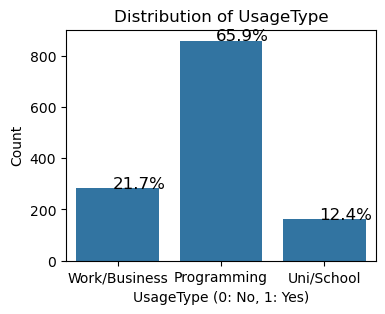

In [7]:
# Analyze the distribution of the target variable
plt.figure(figsize=(4, 3))
ax = sns.countplot(x=target, data=df)
plt.title('Distribution of '+ target)
plt.xlabel(target + ' (0: No, 1: Yes)')
plt.ylabel('Count')

# Add percentage labels
total = len(df[target])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05  # Adjust position if needed
    y = p.get_y() + p.get_height()            
    ax.annotate(percentage, (x, y), size=12)  # Adjust size if needed

plt.show()



In [8]:
label_encoders = {}
original_df = df.copy()
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    class_names = le.classes_

In [9]:
original_df.to_csv("prosseced_dataset_class.csv")
df.to_csv("encoded_dataset_class.csv")
df.head()
original_df.head()

,Unnamed: 0,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Screen,ScreenW,...,IPSpanel,RetinaDisplay,CPU_brand,CPU_base_clock_speed,PrimaryStorage,PrimaryStorageType,SecondaryStorage,SecondaryStorageType,GPU_company,UsageType
0,0,Apple,Ultrabook,13.3,8.0,macOS,1.37,1339.69,Standard,2560.0,...,Yes,Yes,Intel,2.3,128,GB SSD,0,No,Intel,Work/Business
1,1,Apple,Ultrabook,13.3,8.0,macOS,1.34,898.94,Standard,1440.0,...,No,No,Intel,1.8,128,GB Flash Storage,0,No,Intel,Work/Business
2,2,HP,Notebook,15.6,8.0,No OS,1.86,575.00,Full HD,1920.0,...,No,No,Intel,2.5,256,GB SSD,0,No,Intel,Programming
3,3,Apple,Ultrabook,15.4,16.0,macOS,1.83,2537.45,Standard,2880.0,...,Yes,Yes,Intel,2.7,512,GB SSD,0,No,AMD,Programming
4,4,Apple,Ultrabook,13.3,8.0,macOS,1.37,1803.60,Standard,2560.0,...,Yes,Yes,Intel,3.1,256,GB SSD,0,No,Intel,Programming


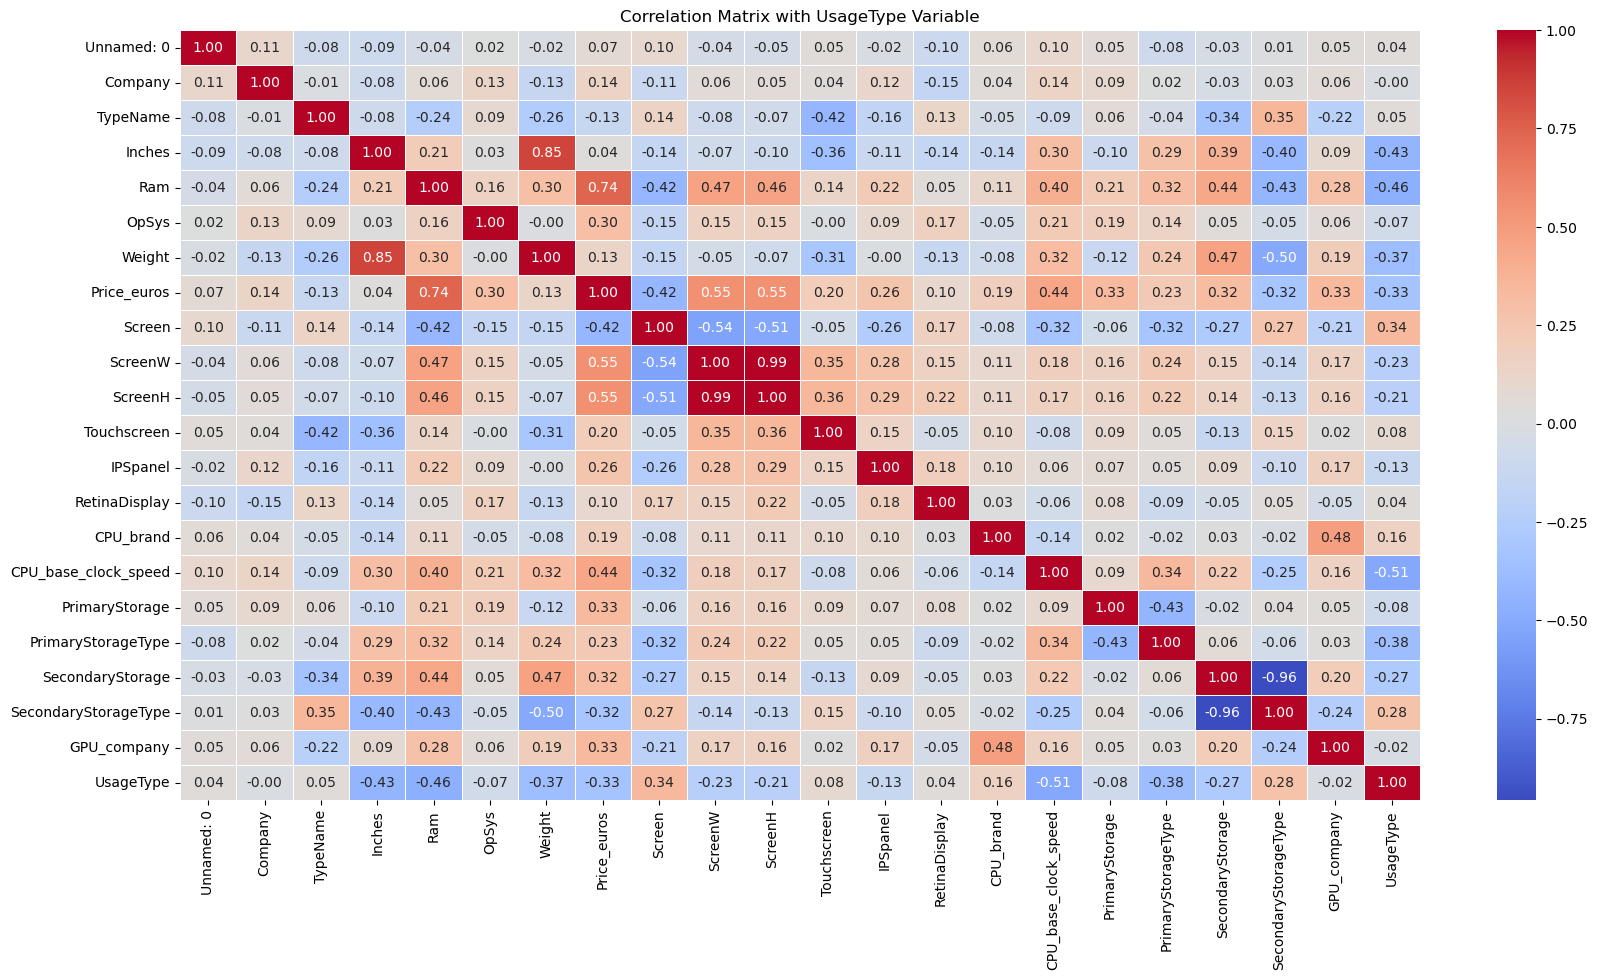


Correlation with Target Variable (UsageType):
Screen                  0.336084
SecondaryStorageType    0.276422
CPU_brand               0.155980
Touchscreen             0.083630
TypeName                0.051941
Unnamed: 0              0.040985
RetinaDisplay           0.037002
Company                -0.003174
GPU_company            -0.023835
OpSys                  -0.068363
PrimaryStorage         -0.079169
IPSpanel               -0.127673
ScreenH                -0.213619
ScreenW                -0.228424
SecondaryStorage       -0.272311
Price_euros            -0.334392
Weight                 -0.370589
PrimaryStorageType     -0.382515
Inches                 -0.430576
Ram                    -0.462185
CPU_base_clock_speed   -0.511319
Name: UsageType, dtype: float64


In [10]:

correlation_matrix = df.corr()
target_correlations = correlation_matrix[target].drop(target) 
plt.figure(figsize=(20, 10)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix with ' + target + ' Variable')
plt.show()
print("\nCorrelation with Target Variable ("+target +"):")
print(target_correlations.sort_values(ascending=False))

#select highly correlated variables


Selected features: ['Inches', 'Ram', 'Weight', 'Price_euros', 'Screen', 'CPU_base_clock_speed', 'PrimaryStorageType']


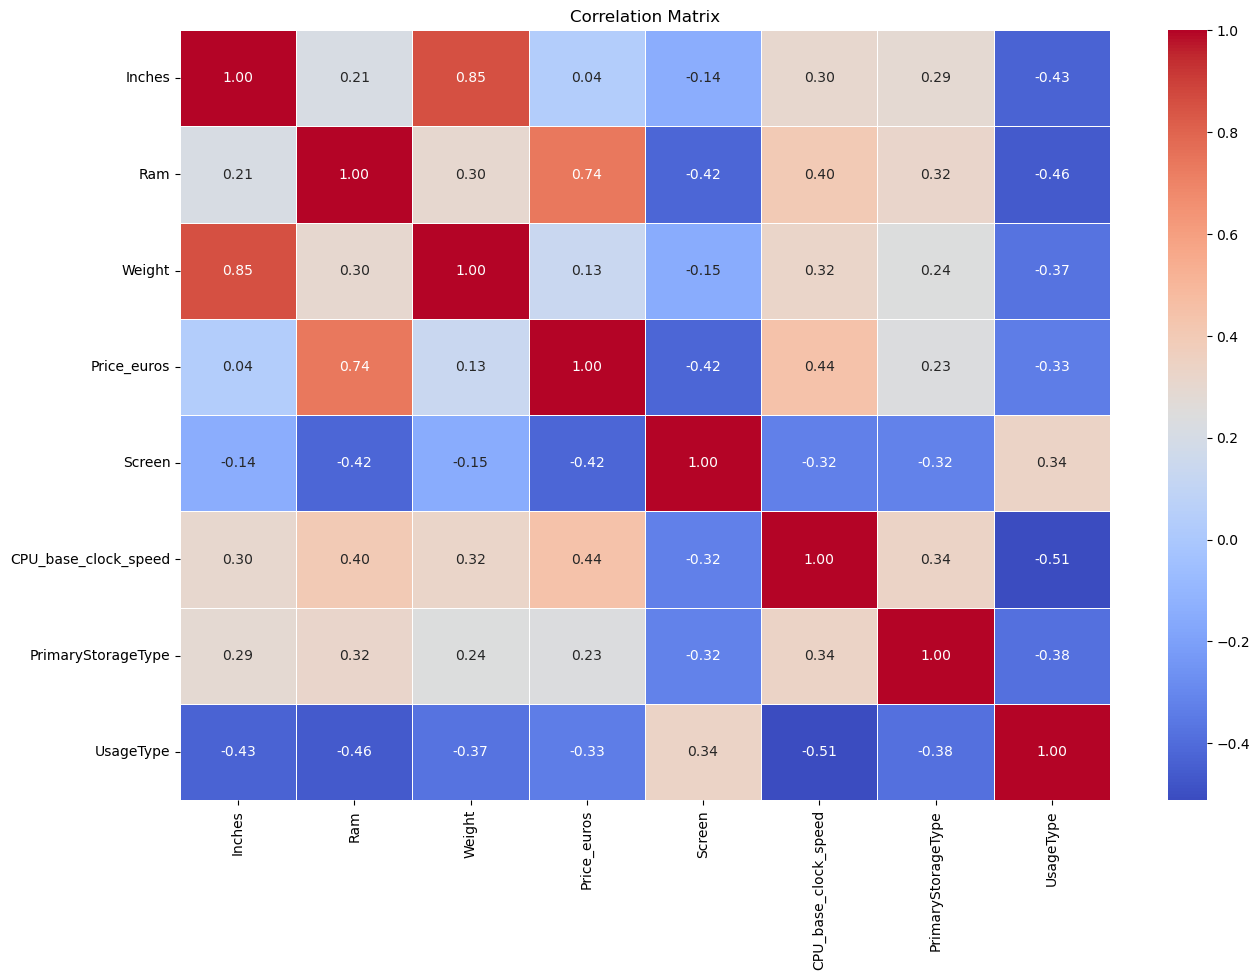

In [11]:

correlation_matrix = df.corr()

# Filter for correlations with the target variable 
target_correlations = correlation_matrix[target].drop(target)  # Exclude self-correlation

# Select features with correlation >= threshold
selected_features = target_correlations[target_correlations.abs() > 0.3].index.tolist()

# Display the selected features
print("Selected features:", selected_features)

# Create a new DataFrame with only the selected features
filtered_df = df[selected_features + [target]]  # Include target variable if needed

correlation_matrix = filtered_df.corr()
# Plot the heatmap
plt.figure(figsize=(15, 10))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


In [12]:
X = df.drop(target, axis=1)
y = df[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.value_counts())

print(y_test.value_counts())


UsageType
0    674
2    230
1    138
Name: count, dtype: int64
UsageType
0    185
2     53
1     23
Name: count, dtype: int64


In [14]:
SVM = ("Support Vector Machine", SVC())
DecisionTree = ("Decision Tree Classifier", DecisionTreeClassifier())
RandForest = ("Random Forest", RandomForestClassifier())
NaiveBayes = ("Naive Bayes", GaussianNB())


In [15]:
# Evaluate classifiers one by one
metrics_data = []

# Evaluate the models
def run_evaluate_model(classifier):
    name, model = classifier[0], classifier[1]  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Display confusion matrix 
    plot_confusion_matrix(y_test, y_pred, name)

In [16]:

# Function to plot confusion matrix for a model
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)  # change color map if you want
    plt.title("Multiclass Confusion Matrix for "+model_name)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



--- Support Vector Machine ---
Accuracy: 0.7318007662835249
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.94      0.85       185
           1       0.45      0.78      0.57        23
           2       0.00      0.00      0.00        53

    accuracy                           0.73       261
   macro avg       0.41      0.57      0.47       261
weighted avg       0.59      0.73      0.65       261



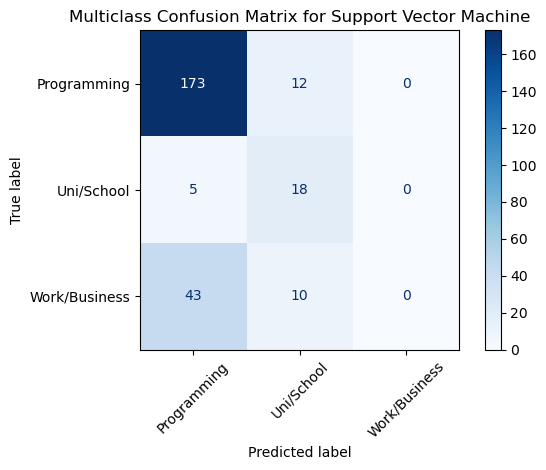

In [17]:
run_evaluate_model(SVM)

--- Decision Tree Classifier ---
Accuracy: 0.9770114942528736
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       185
           1       0.88      0.91      0.89        23
           2       0.96      0.92      0.94        53

    accuracy                           0.98       261
   macro avg       0.94      0.95      0.94       261
weighted avg       0.98      0.98      0.98       261



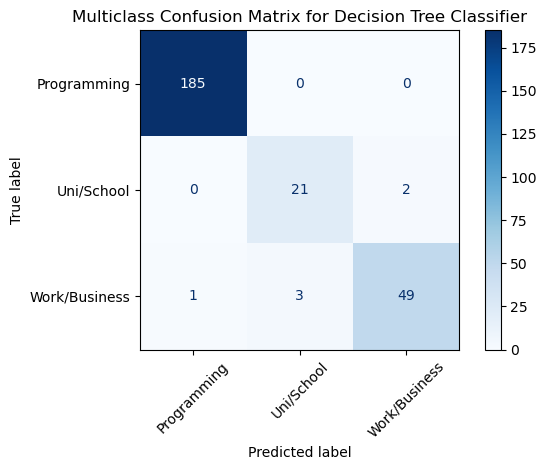

In [18]:
run_evaluate_model(DecisionTree)


--- Random Forest ---
Accuracy: 0.9808429118773946
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       185
           1       0.92      0.96      0.94        23
           2       0.98      0.92      0.95        53

    accuracy                           0.98       261
   macro avg       0.96      0.96      0.96       261
weighted avg       0.98      0.98      0.98       261



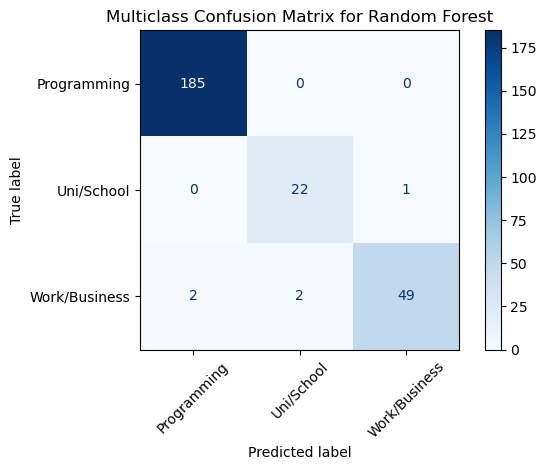

In [19]:
run_evaluate_model(RandForest)

--- Naive Bayes ---
Accuracy: 0.7394636015325671
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.83       185
           1       0.52      0.96      0.68        23
           2       0.46      0.77      0.58        53

    accuracy                           0.74       261
   macro avg       0.66      0.81      0.69       261
weighted avg       0.85      0.74      0.76       261



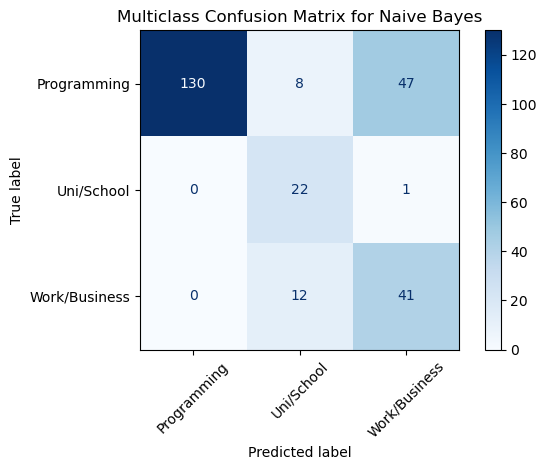

In [20]:
run_evaluate_model(NaiveBayes)

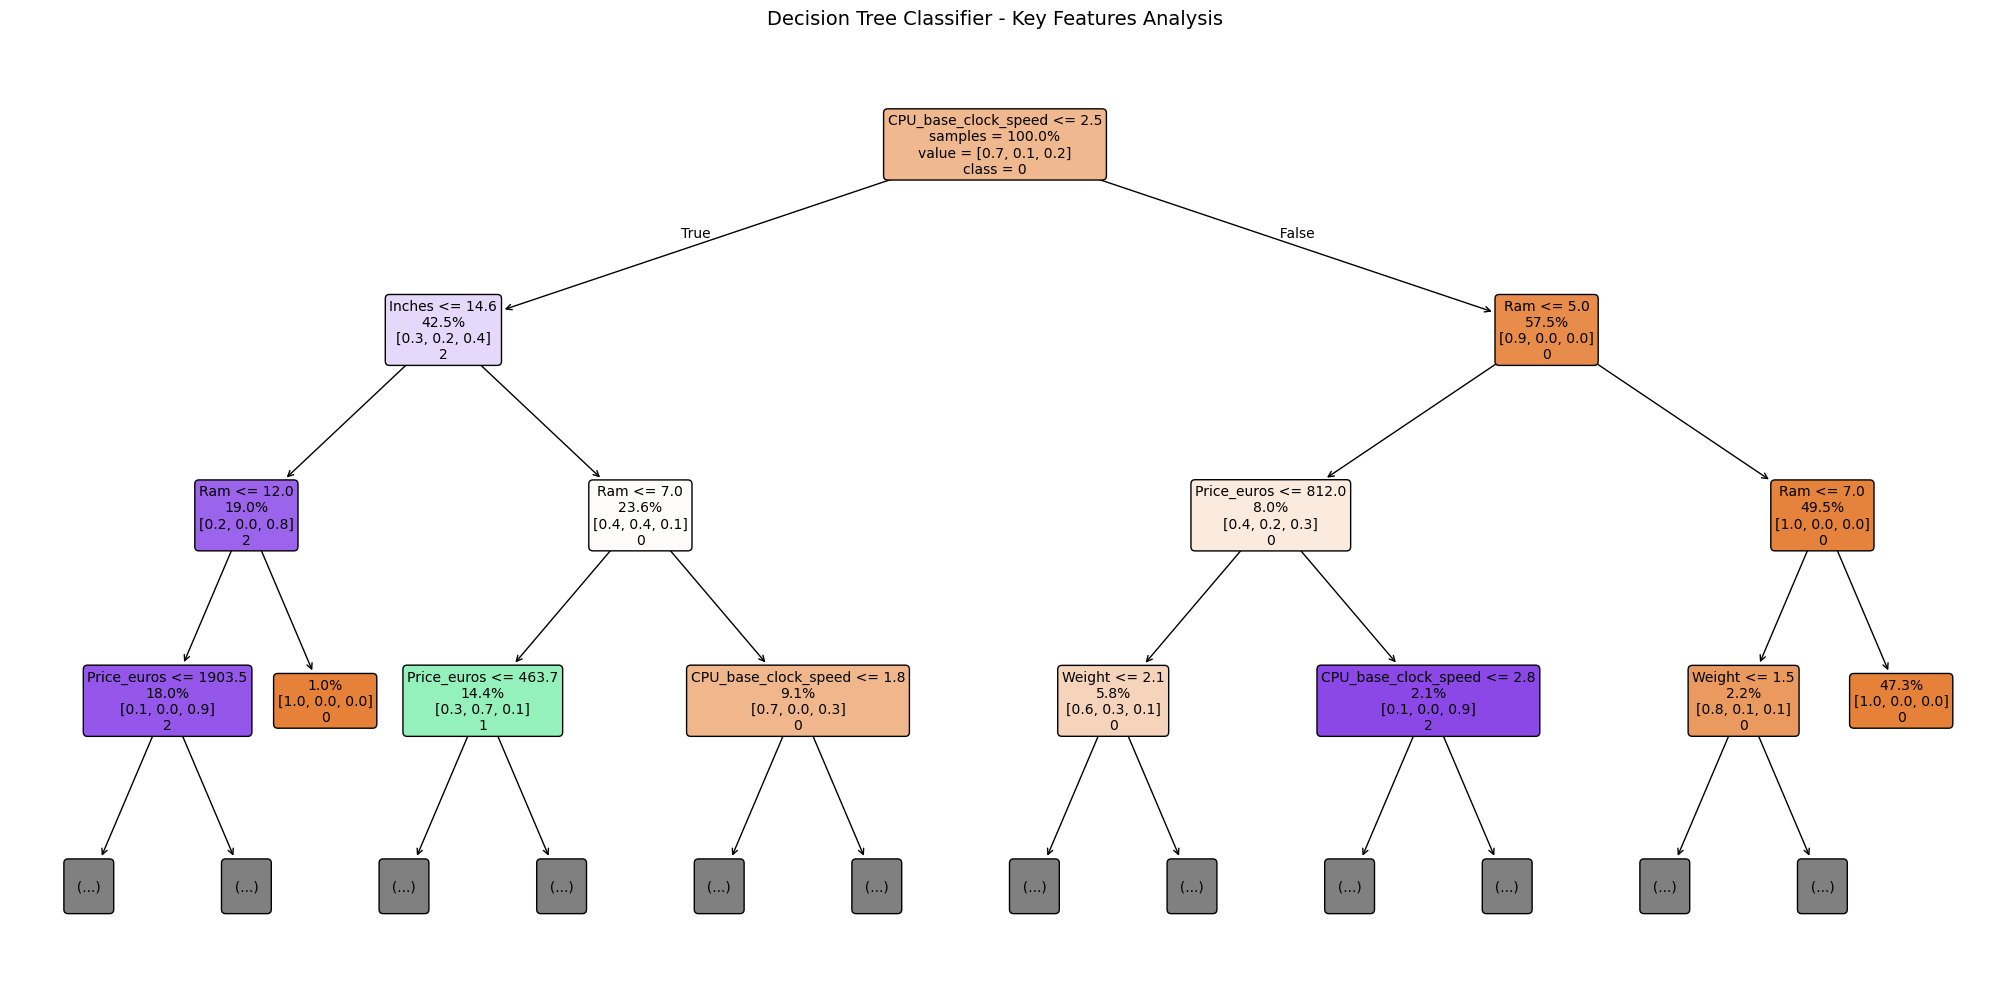

In [21]:

model = DecisionTreeClassifier( random_state=42)

# Important features (using your selection)
X_small = X[selected_features]
model.fit(X_small, y)

plt.figure(figsize=(20, 10), dpi=100)

# Customize the tree plot
tree_plot = plot_tree(model, 
                     feature_names=selected_features, 
                     class_names=model.classes_.astype(str),
                     filled=True, 
                     rounded=True,
                     fontsize=10,
                     proportion=True,
                     impurity=False,
                     precision=1,
                     label='root',
                     max_depth=3)

# Add title and adjust layout
plt.title("Decision Tree Classifier - Key Features Analysis", 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()

